#Guide Credit: https://www.tensorflow.org/tutorials/keras/text_classification

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.



In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [5]:
print(tf.__version__)

2.5.0


#Sentiment analysis
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

I'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.



#Download and explore the IMDB dataset
Let's download and extract the dataset, then explore the directory structure.

In [6]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 1s 0us/step


In [7]:
os.listdir(dataset_dir)

['test', 'imdb.vocab', 'imdbEr.txt', 'train', 'README']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsup',
 'labeledBow.feat',
 'urls_pos.txt',
 'unsupBow.feat',
 'neg',
 'pos',
 'urls_unsup.txt',
 'urls_neg.txt']

The acIImb/train/pos and acIImb/train/neg directories contain may tet files, each of which is a single movie review. Let's take a look at one of them.

In [9]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f: 
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


#Load the dataset

Next, I wil load the data off disk and prepare it into a format suitable for training. To do so, I will use the helpful text_dataset_from_directory utility, which expects a directory structure as follows. 

In [11]:
"""
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt"""

'\nmain_directory/\n...class_a/\n......a_text_1.txt\n......a_text_2.txt\n...class_b/\n......b_text_1.txt\n......b_text_2.txt'

To prepare a dataset for binary classification, I will need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews, which can be found in acIImb/train/pos and acIImb/train/neg. As the IMDB dataset contains additional folders, I will remove them before using this utility.

In [12]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, I will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset. tf.data is a powerful collection of tools for working with data. 

When runing a machine learning experiment, it is a best practice to divide my dataset into three splits: train, validation, and test. 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below. 

In [13]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size, 
    validation_split = 0.2, 
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As we can see above, there are 25,000 examples in the training folder, of which I will use 80% (or 20,000) for training. As we will see in a moment, I can train a model by passing a dataset directly to model.fit. If I'm new to tf.data, I can also iterate over the dataset and print out a few examples as follows. 

In [14]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like <br/>). I will show you how to handle these in the following section.


The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, I can check the class_names property on the dataset.

In [15]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, I will create a validation and test dataset. I will use the remaining 5,000 reviews from the training set for validation.

Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle = False, so that the validation and training splits have no overlap.

In [16]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size, 
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [17]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size = batch_size)

Found 25000 files belonging to 2 classes.


Note: The preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

#Prepare the dataset for training
Next, I will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As seen above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). I will write a custom standardization function to remove the HTML.



Note: To prevent train/test skew (also known as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the TextVectorization layer can be included directly inside my model, as shown later in this tutorial. 

In [18]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', '')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, I will create a TextVectorization layer. I will use this layer to standardize, tokenize, and vectorize our data. I set the output_mode to int to create unique integer indicies for each token. 

Now that I'm using the default split function, and the custom standardization function I defined above. I'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values. 

In [19]:
max_features = 1000
sequence_length = 250 

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

Next, I will call adapt to fit the state of the preprocessing layer to the dataset. This will caue the model to build an index of strings to integers. 

Note: It's import to only use the training data when calling adapt (using the test set would leak information).

In [21]:
#Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [22]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [23]:
#retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  1,  15,  28,   5,   2, 240,  91,   5,  31,  60,   4,   1,   1,
         36, 259,  37,   9,   1,  35,   2,   1,  43, 384,   1,  16,   4,
          1,  12,  43,   1, 297,   2,  86, 225,  53,   1,   1,  20, 981,
         18,  52,  53,   1, 252, 328,  34,  40,   1,   3, 289,  60,  44,
          6,   1,   4,   1,  94,  23, 182,   2,   1, 100,   1, 337, 158,
          1,   1,   4, 814, 563,  30,   4, 846, 271,   3, 747, 747,  50,


As we can see above, each token has been replaced by an integer. We can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

I am nearly ready to train my model. As a final preprocessing step, I will apply the TextVectorization layer I created earlier to the train, validation, and test dataset.

In [26]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

#Configure the dataset for performance

These are two import methods I should use when loading data to make sure that I/O does not become blocking. 

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training my model. If my dataset is too large ot fit into memory, I can also use this method to create a performant on-disk cache, which is more efficient to read than many small files. 

.prefetch() overlaps data preprocessign and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the data performance guide.




In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Create the model

In [28]:
embedding_dim = 16

In [29]:
model = tf.keras.Sequential([
                             layers.Embedding(max_features + 1, embedding_dim),
                             layers.Dropout(0.2),
                             layers.GlobalAveragePooling1D(),
                             layers.Dropout(0.2),
                             layers.Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          16016     
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 16,033
Trainable params: 16,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1) The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the word embedding tutorial.


2) Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.


3) This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.


4) The last layer is densely connected with a single output node.


#Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), I'll use losses.BinaryCrossentropy loss function.

Now, configure the model to use an optimizer and a loss function:




In [30]:
model.compile(loss = losses.BinaryCrossentropy(from_logits = True), 
              optimizer = 'adam',
              metrics = tf.metrics.BinaryAccuracy(threshold = 0.0))

#Train the model

I will train the model by passing the dataset object into the fit method

In [32]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5850 - binary_accuracy: 0.7592 - val_loss: 0.5430 - val_binary_accuracy: 0.7842
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5027 - binary_accuracy: 0.8008 - val_loss: 0.4758 - val_binary_accuracy: 0.8084
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4491 - binary_accuracy: 0.8223 - val_loss: 0.4352 - val_binary_accuracy: 0.8242
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4158 - binary_accuracy: 0.8327 - val_loss: 0.4110 - val_binary_accuracy: 0.8326
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3950 - binary_accuracy: 0.8387 - val_loss: 0.3954 - val_binary_accuracy: 0.8352
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3802 - binary_accuracy: 0.8418 - val_loss: 0.3849 - val_binary_accuracy: 0.8382
Epoch 7/10
625/625 [==============================] - 2s 4ms/ste

#Evaluate the model
Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [33]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3599 - binary_accuracy: 0.8446
Loss:  0.359889954328537
Accuracy:  0.8446000218391418


This fairly naive approach achieves an accuracy of about 84%.



#Create a plot of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that happened during training:



In [34]:
history_dict = history.history
history_dict.keys()



dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. I can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

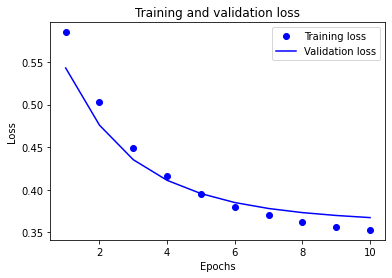

In [35]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

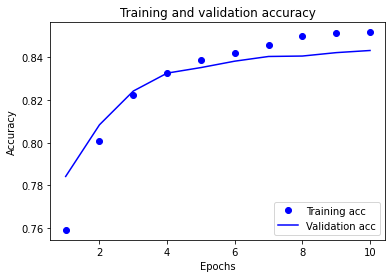

In [36]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the tf.keras.callbacks.EarlyStopping callback.

#Export the model
In the code above, I applied the TextVectorization layer to the dataset before feeding text to the model. If I want to make my model capable of processing raw strings (for example, to simplify deploying it), I can include the TextVectorization layer inside my model. To do so, I can create a new model using the weights I just trained.

In [37]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3599 - accuracy: 0.8446
0.8446000218391418


#Inference on new data
To get predictions for new examples, you can simply call model.predict().

In [38]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)



array([[0.6120031],
       [0.4242775],
       [0.3442914]], dtype=float32)

Including the text preprocessing logic inside my model enables me to export a model for production that simplifies deployment, and reduces the potential for train/test skew.

There is a performance difference to keep in mind when choosing where to apply my TextVectorization layer. Using it outside of my model enables me to do asynchronous CPU processing and buffering of my data when training on GPU. So, if I'm training my model on the GPU, I probably want to go with this option to get the best performance while developing my model, then switch to including the TextVectorization layer inside my model when I'm ready to prepare for deployment.

